In [53]:
import sys
from pathlib import Path

In [54]:
%load_ext autoreload
%autoreload 3 -p
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## imports

In [55]:
import torch
from torch import nn
from torchvision.transforms.functional import to_pil_image

In [56]:
import yolov1
from yolov1.config import parse_config

In [57]:
from yolov1.data.dataset import YOLODataset
from yolov1.utils.vis import draw_boxes_pil, draw_boxes_tensor

In [58]:
from yolov1.utils.general import decode_labels

In [59]:
import matplotlib.pyplot as plt

## config

In [60]:
config_path = "../../yolov1/src/yolov1/configs/default.yaml"

In [19]:
config = parse_config(config_file=config_path)

config

YOLOConfig(data=DataConfig(root='/home/ajkdrag/workspace/projects/architectures-impl-pytorch/.data', train='valid', val='valid', names=['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck'], augmentations=AugmentationsConfig(horizontal_flip=0.8, vertical_flip=0.0, brightness_contrast=0.8, shift_scale_rotate=0.0, random_crop=0.8, random_crop_dims=(224.0, 224.0))), training=TrainingConfig(epochs=100, dls_kwargs={'pin_memory': True, 'batch_size': 32, 'drop_last': True, 'num_workers': 2}, optim_kwargs={'lr': 0.001, 'weight_decay': 0.0001}, checkpoints_dir='/home/ajkdrag/workspace/projects/architectures-impl-pytorch/checkpoints', save_freq=20, loss=LossConfig(l_coord=5.0, l_obj=1.5, l_noobj=0.5, l_class=1.0)), inference=InferenceConfig(checkpoint='/home/ajkdrag/workspace/projects/architectures-impl-pytorch/checkpoints/final_epoch_50.pt', source='/home/ajkdrag/workspace/projects/architectures-impl-pytorch/.data/valid/images', dls_kwargs={'pin_memory': False, 'batch_size': 4, 'drop_last': False, 

## dataset

In [101]:
train_ds = YOLODataset(config, mode="train", encode=True, apply_aug=False)

2024-05-09T06:35:36.044767Z [info     ] Loaded 250 samples             func_name=get_data lineno=68


In [102]:
first = train_ds[2]

In [13]:
decoded = decode_labels(first[1], config.model.S, config.model.B, config.model.nc)

In [14]:
decoded.shape

torch.Size([2, 7])

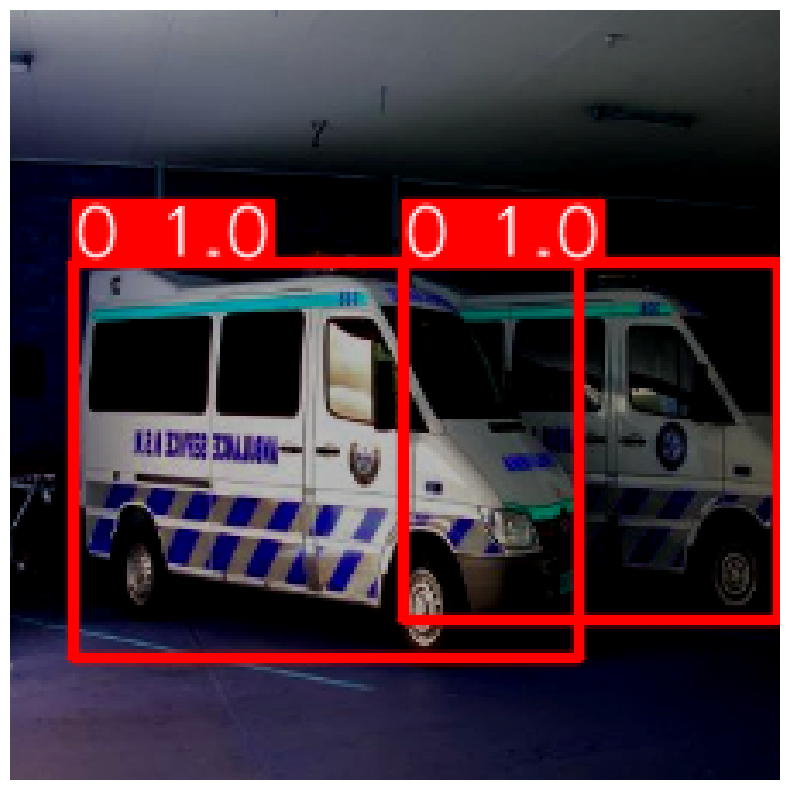

In [15]:
draw_boxes_tensor(first[0], decoded)

In [34]:
class YOLOOutputLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x.shape = [batch, S, S, B * 5 + C]
        classes = self.softmax(x[..., 5:])
        coordinates = self.sigmoid(x[..., :5])
        return torch.cat([coordinates, classes], dim=-1)

In [35]:
out_layer = YOLOOutputLayer()

In [48]:
ip = torch.randn(1, 2, 2, 7)

In [51]:
ip

tensor([[[[ 0.6083, -0.8004,  0.3549,  0.7800, -0.2556, -0.3709, -0.8553],
          [-0.2200, -0.5539,  0.1833, -0.2664, -1.1246, -0.3953,  2.7174]],

         [[-0.8169, -0.8647, -2.1611,  0.5469,  0.4816, -1.1873, -0.5796],
          [ 0.9504,  1.7422,  0.8437, -0.1411,  0.4239,  0.4925,  1.4596]]]])

In [52]:
out_layer(ip)

tensor([[[[0.6476, 0.3099, 0.5878, 0.6857, 0.4365, 0.6188, 0.3812],
          [0.4452, 0.3650, 0.5457, 0.4338, 0.2452, 0.0426, 0.9574]],

         [[0.3064, 0.2964, 0.1033, 0.6334, 0.6181, 0.3526, 0.6474],
          [0.7212, 0.8510, 0.6993, 0.4648, 0.6044, 0.2755, 0.7245]]]])

## loss

In [21]:
targets = first[1].unsqueeze(0)

In [22]:
target_boxes = targets[..., :4]
target_conf = targets[..., 4].unsqueeze(-1)
target_class = targets[..., 5:]



In [23]:
target_boxes.shape, target_conf.shape, target_class.shape

(torch.Size([1, 7, 7, 4]), torch.Size([1, 7, 7, 1]), torch.Size([1, 7, 7, 5]))

In [25]:
obj_mask = target_conf.squeeze(-1) > 0

In [28]:
sum(obj_mask.flatten())

tensor(2)

In [32]:
target_class[obj_mask]

tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]])

In [33]:
from yolov1.utils.loss import SimplifiedYOLOLossV2

In [35]:
loss = SimplifiedYOLOLossV2(config.model.nc)

In [39]:
loss(targets, targets*0.5)

(tensor(1.7413), tensor(1.2413), tensor(0.2500), tensor(0.2500), tensor(0.))

## model

In [41]:
import timm

In [44]:
model = timm.create_model("resnet18", pretrained=True, num_classes=0)

Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


In [45]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [46]:
res = model(torch.rand([1, 3, 224, 224]))

In [49]:
res2 = model(torch.rand([1, 3, 512, 512]))

In [50]:
res.shape, res2.shape

(torch.Size([1, 512]), torch.Size([1, 512]))

## testing arch

In [47]:
from yolov1.models.arch import YOLOv1

In [48]:
yarch = YOLOv1(config.model)

Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


In [49]:
total_params = count_parameters(yarch)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 1301482


In [50]:
yarch(torch.rand([1, 3, 512, 512])).shape

torch.Size([1, 7, 7, 10])

In [51]:
yarch(torch.rand([1, 3, 224, 224])).shape

torch.Size([1, 7, 7, 10])

## testing old loss

In [134]:
from yolov1.utils.loss import SimplifiedYOLOLossV2

Reloading 'yolov1.utils.loss'.


In [135]:
config.training.loss

LossConfig(l_coord=1.0, l_obj=1.0, l_noobj=1.0, l_class=1.0)

In [136]:
old_loss = SimplifiedYOLOLossV2(config)

## testing new loss

In [22]:
targets = first[1].unsqueeze(0)

In [23]:
targets.shape

torch.Size([1, 7, 7, 10])

In [24]:
predictions = torch.rand_like(targets)

#### old loss values

In [137]:
old_values = old_loss(predictions, targets)

In [138]:
old_values

(tensor(22.1680),
 tensor(1.4918),
 tensor(0.2396),
 tensor(17.2694),
 tensor(3.1672))

In [109]:
old_values

(tensor(22.1680),
 tensor(1.4918),
 tensor(0.2396),
 tensor(17.2694),
 tensor(3.1672))

In [126]:
torch.flatten(
                pred_boxes[obj_mask],
                
            )

tensor([0.2884, 0.6434, 0.9144, 0.7902, 0.4108, 0.8232, 0.1314, 0.7232])

In [127]:
pred_boxes[obj_mask].shape

torch.Size([2, 4])

In [132]:
coord_loss = mse(pred_boxes[obj_mask], target_boxes[obj_mask])

Reloading 'yolov1.utils.loss'.


In [133]:
coord_loss

tensor(1.4918)

In [125]:
torch.flatten(
                pred_boxes[obj_mask],
                start_dim=0,
                end_dim=-2,
            )
            

tensor([[0.2884, 0.6434, 0.9144, 0.7902],
        [0.4108, 0.8232, 0.1314, 0.7232]])

#### new loss values

In [111]:
exists_box = targets[..., 4].unsqueeze(3)

In [112]:
targets[..., 4].shape, exists_box.shape

(torch.Size([1, 7, 7]), torch.Size([1, 7, 7, 1]))

In [113]:
# box loss

In [114]:
box_predictions = exists_box * predictions[..., :4]

In [115]:
box_targets = exists_box * targets[..., :4]

In [116]:
box_loss = mse(
    torch.flatten(box_predictions, end_dim=-2),
    torch.flatten(box_targets, end_dim=-2),
)

In [118]:
box_loss

tensor(1.4918)

In [59]:
# obj_loss

In [119]:
object_loss = mse(
    torch.flatten(exists_box * predictions[..., 4:5]),
    torch.flatten(exists_box * targets[..., 4:5]),
)

In [120]:
object_loss

tensor(0.2396)

In [81]:
# noobj loss

In [83]:
no_object_loss = mse(
            torch.flatten((1 - exists_box) * predictions[..., 4:5], start_dim=1),
            torch.flatten((1 - exists_box) * targets[..., 4:5], start_dim=1),
        )

In [84]:
no_object_loss

tensor(17.2694)

In [92]:
# class loss

Reloading 'yolov1.utils.loss'.


In [93]:
class_loss = mse(
            torch.flatten(exists_box * predictions[..., 5:], end_dim=-2,),
            torch.flatten(exists_box * targets[..., 5:], end_dim=-2,),
        )

In [94]:
class_loss

tensor(3.1672)

In [1]:
def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss